In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from scipy import stats

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, r2_score
from sklearn.utils import resample

import h2o
from h2o.frame import H2OFrame
from h2o.estimators import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

# explortary analysis

In [4]:
df = pd.read_csv("employee_retention_data.csv")

In [6]:
df.describe()

employee_id    company_id     seniority         salary
count   24702.000000  24702.000000  24702.000000   24702.000000
mean   501604.403530      3.426969     14.127803  138183.345478
std    288909.026101      2.700011      8.089520   76058.184573
min        36.000000      1.000000      1.000000   17000.000000
25%    250133.750000      1.000000      7.000000   79000.000000
50%    500793.000000      2.000000     14.000000  123000.000000
75%    753137.250000      5.000000     21.000000  187000.000000
max    999969.000000     12.000000     99.000000  408000.000000

In [7]:
df.isna().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

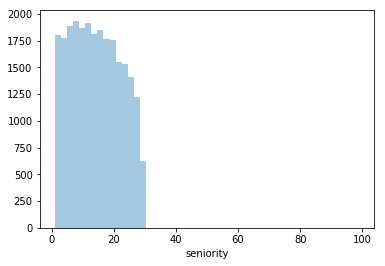

In [8]:
sns.distplot(df['seniority'], hist=True, kde=False)

In [9]:
print(df.shape)
df = df.loc[df['seniority']<40]
print(df.shape)

(24702, 7)
(24700, 7)


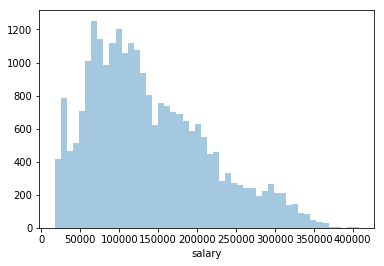

In [10]:
sns.distplot(df['salary'], hist=True, kde=False)

In [21]:
dir(f)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bottom_axes',
 '_clean_axis',
 '_col_var',
 '_col_wrap',
 '_colors',
 '_dropna',
 '_facet_color',
 '_facet_plot',
 '_finalize_grid',
 '_get_palette',
 '_hue_var',
 '_inner_axes',
 '_left_axes',
 '_legend',
 '_legend_data',
 '_legend_out',
 '_margin_titles',
 '_n_facets',
 '_ncol',
 '_not_bottom_axes',
 '_not_left_axes',
 '_not_na',
 '_nrow',
 '_row_var',
 '_space_needed',
 '_update_legend_data',
 '_x_var',
 '_y_var',
 'add_legend',
 'ax',
 'axes',
 'col_names',
 'data',
 'despine',
 'facet_axis',
 'facet_data',
 'fig',
 'hue_kws',
 'hue_names',
 'map',
 'map_dataframe',
 'row_names',
 'savefig',
 'set',
 'set_axis_label

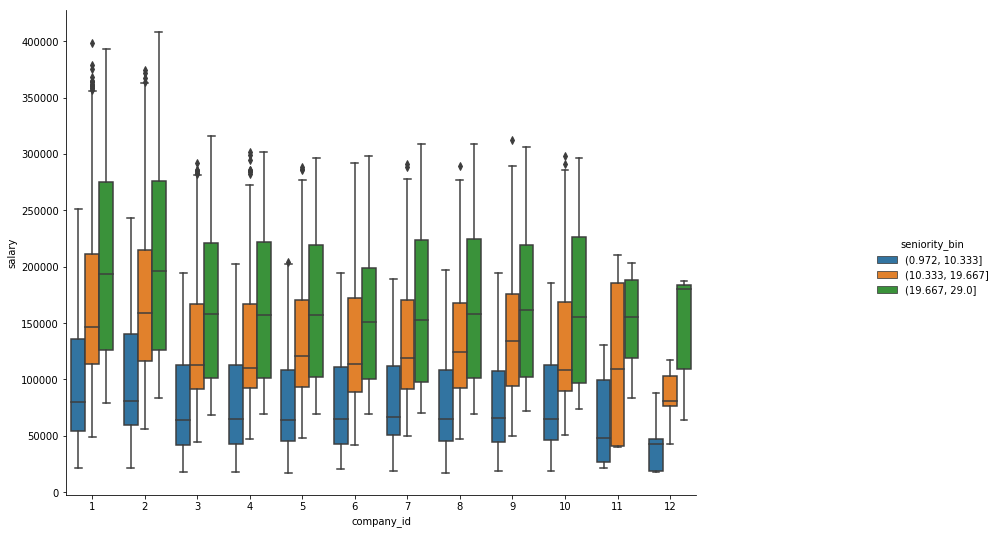

In [26]:
df['seniority_bin'] = pd.cut(df['seniority'], bins=3)
f = sns.catplot(data=df, kind='box', x='company_id', y='salary', hue='seniority_bin')
f.fig.set_size_inches(16, 8)

# Question 1: create tables with 3 columns: day, employee_headcount, company_id

In [27]:
df.dtypes

employee_id       float64
company_id          int64
dept               object
seniority           int64
salary            float64
join_date          object
quit_date          object
seniority_bin    category
dtype: object

In [28]:
df['join_date'] = pd.to_datetime(df['join_date'], errors='coerce')
df['quit_date'] = pd.to_datetime(df['quit_date'], errors='coerce')
df.head()

employee_id  company_id              dept  seniority    salary  join_date  \
0      13021.0           7  customer_service         28   89000.0 2014-03-24   
1     825355.0           7         marketing         20  183000.0 2013-04-29   
2     927315.0           4         marketing         14  101000.0 2014-10-13   
3     662910.0           7  customer_service         20  115000.0 2012-05-14   
4     256971.0           2      data_science         23  276000.0 2011-10-17   

   quit_date     seniority_bin  
0 2015-10-30    (19.667, 29.0]  
1 2014-04-04    (19.667, 29.0]  
2        NaT  (10.333, 19.667]  
3 2013-06-07    (19.667, 29.0]  
4 2014-08-22    (19.667, 29.0]

In [29]:
df.dtypes

employee_id             float64
company_id                int64
dept                     object
seniority                 int64
salary                  float64
join_date        datetime64[ns]
quit_date        datetime64[ns]
seniority_bin          category
dtype: object

In [32]:
df['join_date'].min(), df['join_date'].max()

(Timestamp('2011-01-24 00:00:00'), Timestamp('2015-12-10 00:00:00'))

In [52]:
%%time

start_date, end_date = df['join_date'].min(), df['join_date'].max()
days, employee_headcount, company_id = [], [], []
companies = df['company_id'].unique()
day = 0
while start_date + datetime.timedelta(days=day) <= end_date:
    date = start_date + datetime.timedelta(days=day)
    for company in companies:
        count_join = df.loc[(df['company_id']==company) & (df['join_date']<=date)].shape[0]
        count_quit = df.loc[(df['company_id']==company) & (df['quit_date']<=date)].shape[0]
        count_stay = count_join - count_quit
        days.append(day)
        employee_headcount.append(count_stay)
        company_id.append(company)
    day += 1

Wall time: 1min 5s


In [56]:
dfhc = pd.DataFrame({"days": days, "company_id": company_id, "employee_headcount": employee_headcount})
dfhc.head()

days  company_id  employee_headcount
0     0           7                   1
1     0           4                  12
2     0           2                  17
3     0           9                   3
4     0           1                  25

In [58]:
dfhc.loc[dfhc['company_id']==1]

days  company_id  employee_headcount
4         0           1                  25
16        1           1                  27
28        2           1                  29
40        3           1                  29
52        4           1                  29
...     ...         ...                 ...
21328  1777           1                3841
21340  1778           1                3863
21352  1779           1                3863
21364  1780           1                3864
21376  1781           1                3865

[1782 rows x 3 columns]

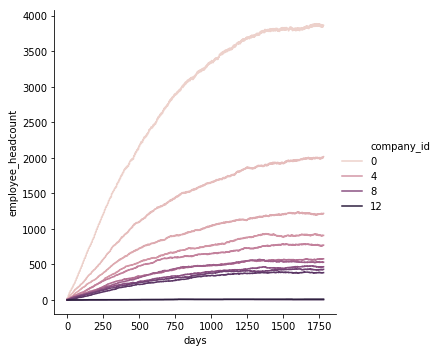

In [72]:
sns.relplot(data=dfhc, kind='line', ci=None, x='days', y='employee_headcount', hue='company_id')

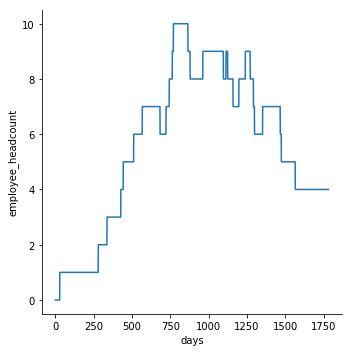

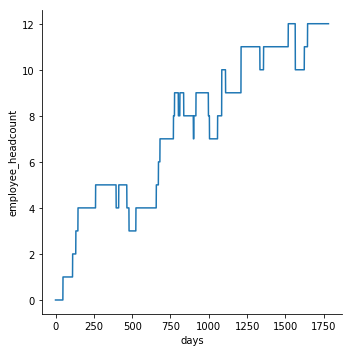

In [67]:
sns.relplot(data=dfhc.loc[dfhc['company_id']==11], kind='line', ci=None, x='days', y='employee_headcount')
sns.relplot(data=dfhc.loc[dfhc['company_id']==12], kind='line', ci=None, x='days', y='employee_headcount')

# Question 2: what factors drive employee churn? 

In [73]:
df.head()

employee_id  company_id              dept  seniority    salary  join_date  \
0      13021.0           7  customer_service         28   89000.0 2014-03-24   
1     825355.0           7         marketing         20  183000.0 2013-04-29   
2     927315.0           4         marketing         14  101000.0 2014-10-13   
3     662910.0           7  customer_service         20  115000.0 2012-05-14   
4     256971.0           2      data_science         23  276000.0 2011-10-17   

   quit_date     seniority_bin  
0 2015-10-30    (19.667, 29.0]  
1 2014-04-04    (19.667, 29.0]  
2        NaT  (10.333, 19.667]  
3 2013-06-07    (19.667, 29.0]  
4 2014-08-22    (19.667, 29.0]

In [74]:
df['dept'].unique()

array(['customer_service', 'marketing', 'data_science', 'engineer',
       'sales', 'design'], dtype=object)

In [78]:
df.groupby('company_id', as_index=True)['dept'].nunique()

company_id
1     6
2     6
3     6
4     6
5     6
6     6
7     6
8     6
9     6
10    6
11    4
12    6
Name: dept, dtype: int64

In [86]:
df['quit'] = df['quit_date'].notna()

## salary

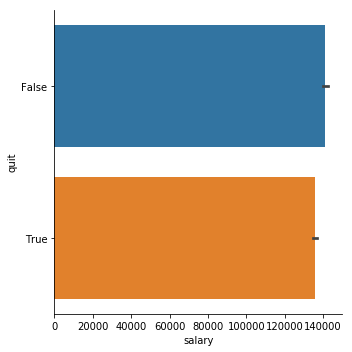

In [88]:
sns.catplot(data=df.astype({'quit':'category'}), kind='bar', x='salary', y='quit')

In [92]:
stats.ttest_ind(df.loc[df['quit']==True]['salary'], df.loc[df['quit']==False]['salary'])

Ttest_indResult(statistic=-5.763520586411431, pvalue=8.335694924613824e-09)

In [93]:
stats.ttest_ind(df.loc[(df['quit']==True) & (df['company_id']==1)]['salary'], 
                df.loc[(df['quit']==False) & (df['company_id']==1)]['salary'])

Ttest_indResult(statistic=-5.336588718124539, pvalue=9.715794568500267e-08)

clearly salary is significant factor for employee quitting. 

## seniority

Ttest_indResult(statistic=-0.04298362740450958, pvalue=0.9657149327010421)

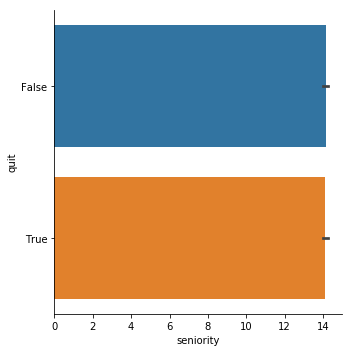

In [95]:
sns.catplot(data=df.astype({'quit':'category'}), kind='bar', x='seniority', y='quit')
stats.ttest_ind(df.loc[df['quit']==True]['seniority'], df.loc[df['quit']==False]['seniority'])

it seems seniority is NOT a significant factor for people quitting

## dept

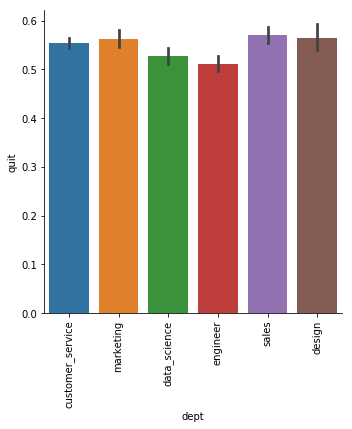

In [109]:
g = sns.catplot(data=df, kind='bar', x='dept', y='quit')
g.set_xticklabels(rotation=90)

overall, sales and design have higher turnover rate than engineer and data_science.

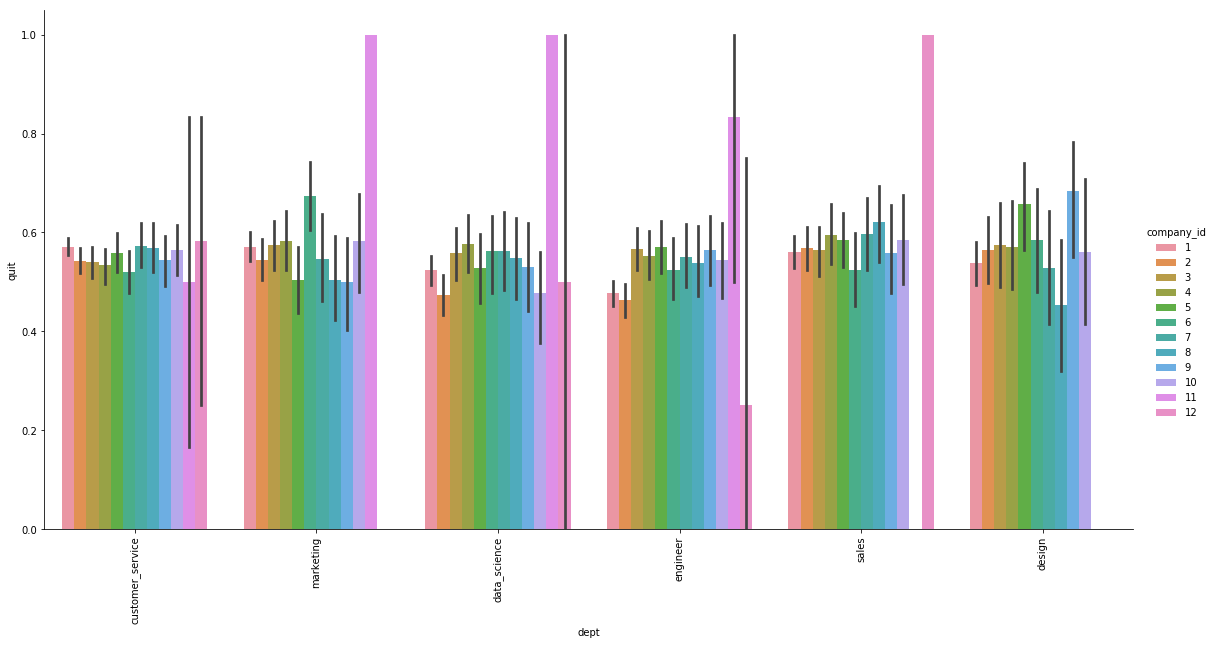

In [111]:
g = sns.catplot(data=df, kind='bar', x='dept', y='quit', hue='company_id', height=8, aspect=2)
g.set_xticklabels(rotation=90)
# g.fig.set_size_inches(16, 8)

In [112]:
a = df.loc[(df['dept']=='data_science') & (df['company_id']==1)]['quit']
b = df.loc[(df['dept']=='engineer') & (df['company_id']==1)]['quit']
stats.ttest_ind(a, b)

Ttest_indResult(statistic=2.357518589179199, pvalue=0.018469989742023112)

there are difference in companies: for example, in company 1, engineers are less likely to quit than data_scientists. However, overall this is not true. 

## time with company

In [114]:
df['days_with_company'] = df['quit_date'] - df['join_date']
df.head()

employee_id  company_id              dept  seniority    salary  join_date  \
0      13021.0           7  customer_service         28   89000.0 2014-03-24   
1     825355.0           7         marketing         20  183000.0 2013-04-29   
2     927315.0           4         marketing         14  101000.0 2014-10-13   
3     662910.0           7  customer_service         20  115000.0 2012-05-14   
4     256971.0           2      data_science         23  276000.0 2011-10-17   

   quit_date     seniority_bin   quit days_with_company  
0 2015-10-30    (19.667, 29.0]   True          585 days  
1 2014-04-04    (19.667, 29.0]   True          340 days  
2        NaT  (10.333, 19.667]  False               NaT  
3 2013-06-07    (19.667, 29.0]   True          389 days  
4 2014-08-22    (19.667, 29.0]   True         1040 days

In [121]:
df['days_with_company'].loc[lambda s: s.notna()].dt.days

0         585
1         340
3         389
4        1040
5         578
         ... 
24690    1452
24692     424
24695    1151
24696     372
24699     780
Name: days_with_company, Length: 13508, dtype: int64

Text(0.5, 0, 'time with company (year)')

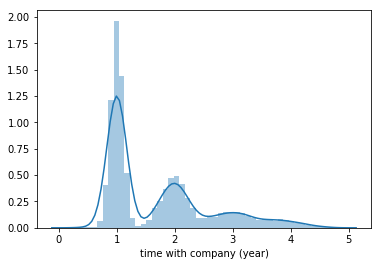

In [127]:
f = sns.distplot(df['days_with_company'].loc[lambda s: s.notna()].dt.days/365 , hist=True, kde=True)
f.set_xlabel('time with company (year)')

clearly, employees quitting peaks around 1 year mark and drops after that. 

## time (month or week) of quitting

Text(0.5, 0, 'quit time (month of year)')

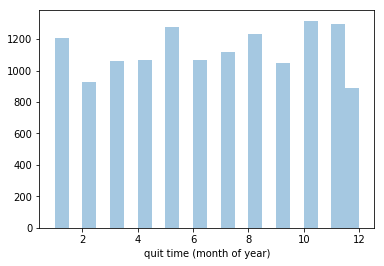

In [133]:
h = sns.distplot(df['quit_date'].loc[lambda s: s.notna()].dt.month, hist=True, kde=False)
h.set_xlabel('quit time (month of year)')

## try out sns.regplot()

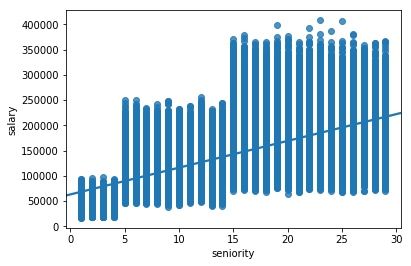

In [134]:
sns.regplot(data=df, x='seniority', y='salary')

# build model to predict quitting

In [136]:
df.head()

employee_id  company_id              dept  seniority    salary  join_date  \
0      13021.0           7  customer_service         28   89000.0 2014-03-24   
1     825355.0           7         marketing         20  183000.0 2013-04-29   
2     927315.0           4         marketing         14  101000.0 2014-10-13   
3     662910.0           7  customer_service         20  115000.0 2012-05-14   
4     256971.0           2      data_science         23  276000.0 2011-10-17   

   quit_date     seniority_bin   quit days_with_company  
0 2015-10-30    (19.667, 29.0]   True          585 days  
1 2014-04-04    (19.667, 29.0]   True          340 days  
2        NaT  (10.333, 19.667]  False               NaT  
3 2013-06-07    (19.667, 29.0]   True          389 days  
4 2014-08-22    (19.667, 29.0]   True         1040 days

In [139]:
# for the ones still with company, calcualte time with company using max join_date
df.loc[df['quit_date'].isna(), 'days_with_company'] = (df['join_date'].max() - df['join_date'])
df.head()

employee_id  company_id              dept  seniority    salary  join_date  \
0      13021.0           7  customer_service         28   89000.0 2014-03-24   
1     825355.0           7         marketing         20  183000.0 2013-04-29   
2     927315.0           4         marketing         14  101000.0 2014-10-13   
3     662910.0           7  customer_service         20  115000.0 2012-05-14   
4     256971.0           2      data_science         23  276000.0 2011-10-17   

   quit_date     seniority_bin   quit days_with_company  
0 2015-10-30    (19.667, 29.0]   True          585 days  
1 2014-04-04    (19.667, 29.0]   True          340 days  
2        NaT  (10.333, 19.667]  False          423 days  
3 2013-06-07    (19.667, 29.0]   True          389 days  
4 2014-08-22    (19.667, 29.0]   True         1040 days

In [140]:
df['days_with_company'] = df['days_with_company'].dt.days
df.head()

employee_id  company_id              dept  seniority    salary  join_date  \
0      13021.0           7  customer_service         28   89000.0 2014-03-24   
1     825355.0           7         marketing         20  183000.0 2013-04-29   
2     927315.0           4         marketing         14  101000.0 2014-10-13   
3     662910.0           7  customer_service         20  115000.0 2012-05-14   
4     256971.0           2      data_science         23  276000.0 2011-10-17   

   quit_date     seniority_bin   quit  days_with_company  
0 2015-10-30    (19.667, 29.0]   True                585  
1 2014-04-04    (19.667, 29.0]   True                340  
2        NaT  (10.333, 19.667]  False                423  
3 2013-06-07    (19.667, 29.0]   True                389  
4 2014-08-22    (19.667, 29.0]   True               1040

In [141]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 9.0.1+11, mixed mode)
  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\IVANEM~1\AppData\Local\Temp\tmpu_lh4r33
  JVM stdout: C:\Users\IVANEM~1\AppData\Local\Temp\tmpu_lh4r33\h2o_IvanEmily_started_from_python.out
  JVM stderr: C:\Users\IVANEM~1\AppData\Local\Temp\tmpu_lh4r33\h2o_IvanEmily_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       America/Chicago
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.0.3
H2O_cluster_version_age:    18 days
H2O_cluster_name:           H2O_from_python_IvanEmily_x927vf
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    1.982 Gb
H2O_cluster_total_cores:    4
H2O_cluster_allowed_cores:  4
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.1 final
--------------------------  ---------------------------------------------------------

In [142]:
df.head()

employee_id  company_id              dept  seniority    salary  join_date  \
0      13021.0           7  customer_service         28   89000.0 2014-03-24   
1     825355.0           7         marketing         20  183000.0 2013-04-29   
2     927315.0           4         marketing         14  101000.0 2014-10-13   
3     662910.0           7  customer_service         20  115000.0 2012-05-14   
4     256971.0           2      data_science         23  276000.0 2011-10-17   

   quit_date     seniority_bin   quit  days_with_company  
0 2015-10-30    (19.667, 29.0]   True                585  
1 2014-04-04    (19.667, 29.0]   True                340  
2        NaT  (10.333, 19.667]  False                423  
3 2013-06-07    (19.667, 29.0]   True                389  
4 2014-08-22    (19.667, 29.0]   True               1040

In [143]:
hdf = H2OFrame(df)
hdf['quit'] = hdf['quit'].asfactor()
hdf['dept'] = hdf['dept'].asfactor()
hdf['company_id'] = hdf['company_id'].asfactor()
hdf.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


employee_id company_id dept seniority salary join_date quit_date seniority_bin quit days_with_company 
 
 
 type int enum enum int int time time enum enum int 
 mins 36.0 1.0 17000.0 1295827200000.0 1318464000000.0 0.0 
 mean 501616.6248987853 14.120971659919004 138176.2753036432 1372503215805.6685 1399051956174.1138 572.9257894736813 
 maxs 999969.0 29.0 408000.0 1449705600000.0 1449619200000.0 1774.0 
 sigma 288908.5332803188 8.054137181668152 76056.33195256838 44438227125.59638 33386059086.042866 361.76612883439594 
 zeros 0 0 0 0 0 2 
 missing 0 0 0 0 0 0 11192 0 0 0 
 0 13021.0 7 customer_service 28.0 89000.0 2014-03-24 00:00:00 2015-10-30 00:00:00 (19.667, 29.0] True 585.0 
 1 825355.0 7 marketing 20.0 183000.0 2013-04-29 00:00:00 2014-04-04 00:00:00 (19.667, 29.0] True 340.0 
 2 927315.0 4 marketing 14.0 101000.0 2014-10-13 00:00:00 (10.333, 19.667] False 423.0 
 3 662910.0 7 customer_service 20.0 115000.0 2012-05-14 00:00:00 2013-06-07 00:00:00 (19.667, 29.0] True 389.0 
 4 256971.0 2 data_science 23.0 276000.0 2011-10-17 00:00:00 2014-08-22 00:00:00 (19.667, 29.0] True 1040.0 
 5 509529.0 4 data_science 14.0 165000.0 2012-01-30 00:00:00 2013-08-30 00:00:00 (10.333, 19.667] True 578.0 
 6 88600.0 4 customer_service 21.0 107000.0 2013-10-21 00:00:00 (19.667, 29.0] False 780.0 
 7 716309.0 2 customer_service 4.0 30000.0 2014-03-05 00:00:00 (0.972, 10.333] False 645.0 
 8 172999.0 9 engineer 7.0 160000.0 2012-12-10 00:00:00 2015-10-23 00:00:00 (0.972, 10.333] True 1047.0 
 9 504159.0 1 sales 7.0 104000.0 2012-06-12 00:00:00 (0.972, 10.333] False 1276.0

In [144]:
train, valid = hdf.split_frame(ratios=[0.7])
features = ['company_id', 'dept', 'seniority', 'salary', 'days_with_company']
target = 'quit'

In [145]:
clf = H2ORandomForestEstimator(balance_classes=True,
                               ntrees=200,
                               max_depth=4)
clf.train(x=features,
         y=target,
         training_frame=train,
         validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [146]:
clf.model_performance(train)


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.18077590030775872
RMSE: 0.4251774927107016
LogLoss: 0.5358271423102884
Mean Per-Class Error: 0.27608780237174246
AUC: 0.8053675357882103
AUCPR: 0.8116431603321117
Gini: 0.6107350715764206

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4891891975137443: 


False     True   Error               Rate
0  False  2912.0   4914.0  0.6279    (4914.0/7826.0)
1   True   146.0   9404.0  0.0153     (146.0/9550.0)
2  Total  3058.0  14318.0  0.2912   (5060.0/17376.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold        value    idx
0                        max f1   0.489189     0.788001  277.0
1                        max f2   0.162149     0.898136  325.0
2                  max f0point5   0.610291     0.747183  147.0
3                  max accuracy   0.579566     0.736763  194.0
4                 max precision   0.750334     0.964286    0.0
5                    max recall   0.087187     1.000000  386.0
6               max specificity   0.750334     0.999744    0.0
7              max absolute_mcc   0.579566     0.468316  194.0
8    max min_per_class_accuracy   0.608413     0.713613  152.0
9   max mean_per_class_accuracy   0.585996     0.723912  186.0
10                      max tns   0.750334  7824.000000    0.0
11                      max fns   0.750334  9496.000000    0.0
12                      max fps   0.066894  7826.000000  399.0
13                      max tps   0.087187  9550.000000  386.0
14                      max tnr   0.750334     0.999744    0.0
15                      max fnr   0.750334     0.994346    0.0
16                      max fpr   0.066894     1.000000  399.0
17                      max tpr   0.087187     1.000000  386.0


Gains/Lift Table: Avg response rate: 54.96 %, avg score: 55.23 %


group  cumulative_data_fraction  lower_threshold      lift  \
0         1                  0.010071         0.747156  1.684315   
1         2                  0.020028         0.745812  1.630167   
2         3                  0.030099         0.744089  1.601139   
3         4                  0.040055         0.743108  1.640684   
4         5                  0.050012         0.742466  1.682753   
5         6                  0.100253         0.739068  1.640238   
6         7                  0.150092         0.735778  1.607274   
7         8                  0.200046         0.729180  1.540686   
8         9                  0.300299         0.673538  1.309772   
9        10                  0.400092         0.613669  1.232921   
10       11                  0.500576         0.609040  1.161922   
11       12                  0.600138         0.598050  1.074858   
12       13                  0.699988         0.568992  0.857828   
13       14                  0.800012         0.501808  0.801910   
14       15                  0.899977         0.106267  0.326814   
15       16                  1.000000         0.065970  0.014656   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          1.684315       0.925714  0.748990                  0.925714   
1          1.657397       0.895954  0.746305                  0.910920   
2          1.638572       0.880000  0.745017                  0.900574   
3          1.639097       0.901734  0.743499                  0.900862   
4          1.647788       0.924855  0.742790                  0.905639   
5          1.644005       0.901489  0.740722                  0.903559   
6          1.631808       0.883372  0.736918                  0.896856   
7          1.609054       0.846774  0.733520                  0.884350   
8          1.509140       0.719862  0.704529                  0.829437   
9          1.440244       0.677624  0.628896                  0.791571   
10         1.384375       0.638603  0.610997                  0.760865   
11         1.333026       0.590751  0.605023                  0.732643   
12         1.265241       0.471470  0.582774                  0.695388   
13         1.207312       0.440736  0.540363                  0.663549   
14         1.109511       0.179620  0.276250                  0.609797   
15         1.000000       0.008055  0.095712                  0.549609   

    cumulative_score  capture_rate  cumulative_capture_rate       gain  \
0           0.748990      0.016963                 0.016963  68.431533   
1           0.747655      0.016230                 0.033194  63.016675   
2           0.746772      0.016126                 0.049319  60.113927   
3           0.745959      0.016335                 0.065654  64.068396   
4           0.745328      0.016754                 0.082408  68.275278   
5           0.743020      0.082408                 0.164817  64.023821   
6           0.740993      0.080105                 0.244921  60.727422   
7           0.739127      0.076963                 0.321885  54.068569   
8           0.727577      0.131309                 0.453194  30.977236   
9           0.702963      0.123037                 0.576230  23.292089   
10          0.684502      0.116754                 0.692984  16.192224   
11          0.671317      0.107016                 0.800000   7.485834   
12          0.658687      0.085654                 0.885654 -14.217191   
13          0.643893      0.080209                 0.965864 -19.809036   
14          0.603057      0.032670                 0.998534 -67.318558   
15          0.552311      0.001466                 1.000000 -98.534369   

    cumulative_gain  
0         68.431533  
1         65.739664  
2         63.857247  
3         63.909731  
4         64.778821  
5         64.400454  
6         63.180805  
7         60.905368  
8         50.914029  
9         44.024437  
10        38.437515  
11        33.302647  
12        26.524145  
13        20.731247  
1

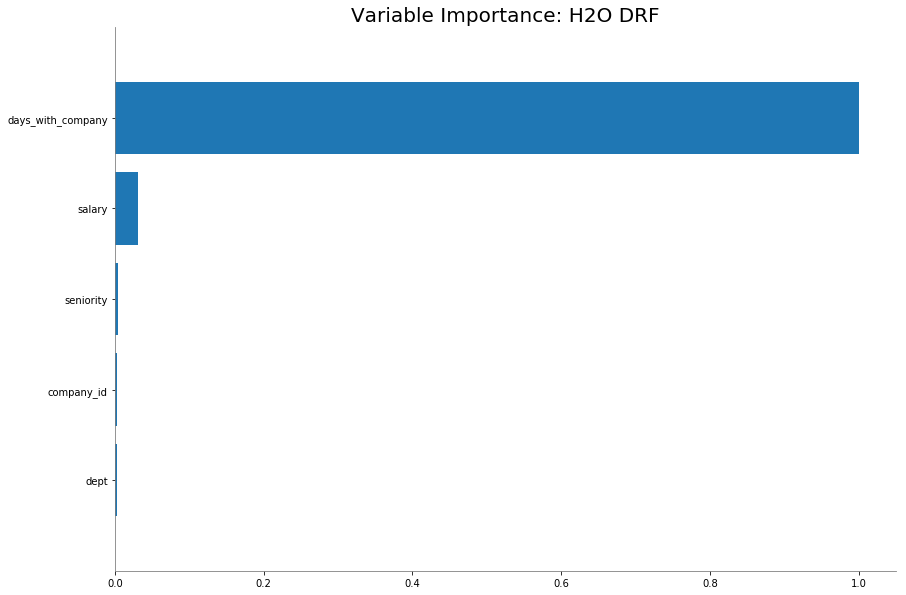

In [147]:
clf.varimp_plot()

Accuray {'train': [[0.5901318828700584, 0.7188809723386421]], 'valid': [[0.5841787095253808, 0.7341616602949208]]}         
AUC {'train': 0.7969070096028122, 'valid': 0.7947722476376283}         
F1 {'train': [[0.4888025159560433, 0.7519068647129666]], 'valid': [[0.46952835075969684, 0.7767759833548004]]}


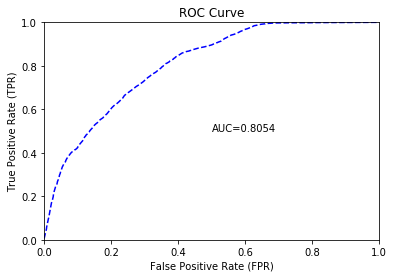

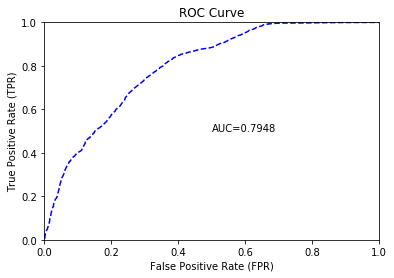

In [155]:
#  clf.model_performance(valid)
print(f"Accuray {clf.accuracy(train=True, valid=True)} \
        \nAUC {clf.auc(train=True, valid=True)} \
        \nF1 {clf.F1(train=True, valid=True)}") 

perf_train = clf.model_performance(train)
perf_valid = clf.model_performance(valid)
perf_train.plot(type='roc')
perf_valid.plot(type='roc')

the main factors for employee churn is time with company and salary. they do make sense.

# More factors to add?
- The one more variable to add to the dataset is time with company.

# calculate and plot the correlation heat map

In [157]:
df.head()

employee_id  company_id              dept  seniority    salary  join_date  \
0      13021.0           7  customer_service         28   89000.0 2014-03-24   
1     825355.0           7         marketing         20  183000.0 2013-04-29   
2     927315.0           4         marketing         14  101000.0 2014-10-13   
3     662910.0           7  customer_service         20  115000.0 2012-05-14   
4     256971.0           2      data_science         23  276000.0 2011-10-17   

   quit_date     seniority_bin   quit  days_with_company  
0 2015-10-30    (19.667, 29.0]   True                585  
1 2014-04-04    (19.667, 29.0]   True                340  
2        NaT  (10.333, 19.667]  False                423  
3 2013-06-07    (19.667, 29.0]   True                389  
4 2014-08-22    (19.667, 29.0]   True               1040

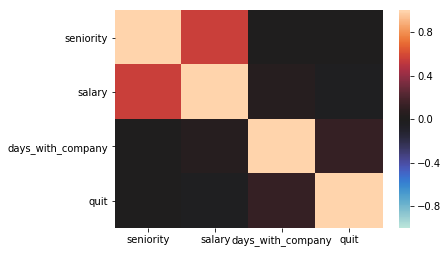

In [162]:
corr = df[['seniority', 'salary', 'days_with_company', 'dept', 'quit']].corr()
sns.heatmap(corr, center=0, vmin=-1, vmax=1)